In [1]:
import ROOT as r
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import colorsys
from scipy import optimize
import os

plt.style.use('ggplot')

Welcome to JupyROOT 6.18/04


In [2]:
"""
Import bigass histograms with all the endgame data, and get the energy projections you want
"""

f = r.TFile("../endgame/EndgameData90Percent.root")

energy_range = [1000, 3100]

calo_hists = []

for i in range(1, 25):
    calo = f.Get("verticalPosition/clusters" + str(i)).Clone("calo_" + str(i))
    
    calo.SetAxisRange(energy_range[0], energy_range[1], "y")
    calo_hists.append(calo.Project3D("zx"))

In [16]:
def periodic(x, a, b, c, d):
    return a * np.exp(x / b) * np.cos(c * x + d)
    #return a * np.cos(c * x + d)

In [7]:
def reject(y, p):
    dec = abs(y[0] % 1)
    if( dec  < 0.6 and 0.4 < dec ):
        r.TF1.RejectPoint()
        return 0
    else:
        return p[0]*math.exp(-((y[0]-p[1])**2)/(2*(p[2]**2)))

In [8]:
def gaus_fit(hist, step, no_spikes=True):
    """
    Performs a Gaussian fit on the distribution of Y hits for a time slice
    
    hist: [TH2D] a histogram containing the y(t) data
    step: [int] the size of each bin for fitting
    no_spikes: [bool] if spikes should be removed. Defaults to False
    """
    stats = []
    
    for index in range(0, hist.GetNbinsX()-step, step):
        a = dict()
        try:
            proj = hist.ProjectionY("_py", index, index+step)
            the_fit = proj.Fit("gaus", "SNQ")
            
            a['TimeBin']      = index*(hist.GetXaxis().GetXmax()/hist.GetNbinsX())
            a['GausConst']    = the_fit.Parameter(0)
            a['GausMean']     = the_fit.Parameter(1)
            a['GausMeanError']= the_fit.Error(1)
            a['GausSD']       = the_fit.Parameter(2)
            a['GausSDError']  = the_fit.Error(2)
            a['ChiSquare']    = the_fit.Chi2() / the_fit.Ndf()
            
            a['HistMean']     = proj.GetMean()
            a['HistMeanError']= proj.GetMeanError()
            a['HistSD']       = proj.GetStdDev()
            a['HistSDError']  = proj.GetStdDevError()
            a['Npoints']      = proj.GetEntries()
            a['RMS']          = proj.GetRMS()
            a['RMSError']     = proj.GetRMSError()
            a['Skewness']     = proj.GetSkewness()
                    
            if(no_spikes == True):
                func = r.TF1("func", reject, 0, 6, 3)
                func.SetParameters(1, 1, 1)
                the_fit_ns = proj.Fit(func, "SNQ")
                  
                a['GausConst_ns']     = the_fit_ns.Parameter(0)
                a['GausMean_ns']      = the_fit_ns.Parameter(1)
                a['GausMeanError_ns'] = the_fit_ns.Error(1)
                a['GausSD_ns']        = abs(the_fit_ns.Parameter(2))
                a['GausSDError_ns']   = the_fit_ns.Error(2)
                a['ChiSquare_ns']     = the_fit_ns.Chi2() / the_fit.Ndf()
                
            else:     # no_spikes == False
                a['GausConst_ns']     = 0
                a['GausMean_ns']      = 0
                a['GausMeanError_ns'] = 0
                a['GausSD_ns']        = 0
                a['ChiSquare_ns']     = 0
                
            stats.append(a)
                
        except:
            continue

    # print(stats)
    data = pd.DataFrame(columns=['TimeBin', 'GausConst', 'GausMean', 'GausMeanError',
                                 'GausSD', 'GausSDError', 'ChiSquare', 'HistMean',
                                 'HistMeanError', 'HistSD', 'HistSDError', 'Npoints', 'RMS',
                                 'Skewness', 'RMSError', 'GausConst_ns',
                                 'GausMean_ns', 'GausMeanError_ns',
                                 'GausSD_ns', 'GausSDError_ns', 'ChiSquare_ns'])
    
    for index in range(0, len(stats)):
        data.loc[index] = stats[index]
    
    return data

In [9]:
def width_at_calo(data, fit_lim=[30, 400]):
    """
    Compute the mean width of the beam at a certain calorimeter. Returns this value
    """
    return data[(data['TimeBin'] > fit_lim[0]) & (data['TimeBin'] < fit_lim[1])]['HistSD'].mean()

In [10]:
def linear_func(coef1, coef2, fit_lim):
    """
    Makes a numpy linspace of a linear function
    """
    
    x = np.linspace(fit_lim[0], fit_lim[1], 100*(fit_lim[1]-fit_lim[0]))
    y = coef1 * x + coef2
    
    return [x, y]

In [11]:
def linear_func_scipy(x, a, b):
    return a * x + b

/home/lars/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RankWarning: Polyfit may be poorly conditioned
  from ipykernel import kernelapp as app
/home/lars/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RankWarning: Polyfit may be poorly conditioned
  from ipykernel import kernelapp as app


LinAlgError: Singular matrix

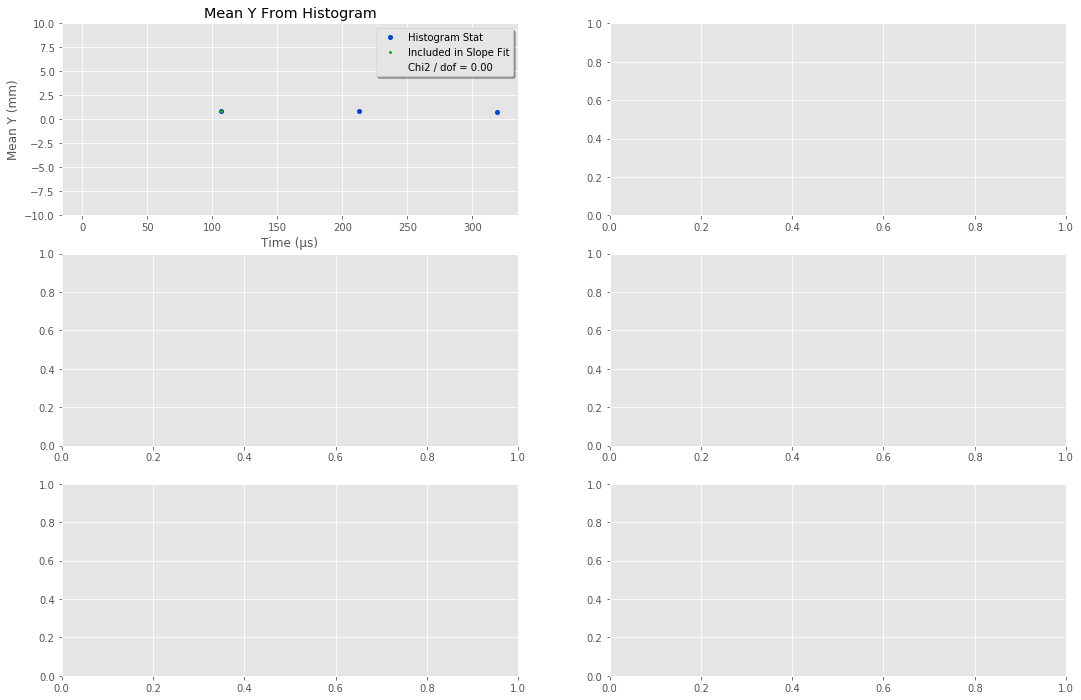

In [18]:
"""
Main fit result plotting

Run this to generate the graphs for the fit results per calorimeter
"""

fit_limits = [30, 200]
mean_limits = [-10, 10]
sd_limits = [-10, 40]
step = 23

for num in range(0, len(calo_hists)):
    if (num < 9):
        plot_fit_results(gaus_fit(calo_hists[num], step, no_spikes=True), 'calo_0' + str(num + 1),
                         mean_lim=mean_limits, sd_lim=sd_limits, fit_lim=fit_limits)
    else:
        plot_fit_results(gaus_fit(calo_hists[num], step, no_spikes=True), 'calo_' + str(num + 1),
                         mean_lim=mean_limits, sd_lim=sd_limits, fit_lim=fit_limits)